In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json

In [7]:
class CompareFeatures():
    def __init__(self):
        #特徴点抽出
        # AgastFeature検出器の生成
#         self.detector = cv2.AgastFeatureDetector_create()
        # FAST検出器の生成
#         self.detector = cv2.FastFeatureDetector_create()
        # MSER検出器の生成
#         self.detector = cv2.MSER_create()

        # 特徴量抽出
        # A-KAZE検出器の生成
#         self.detector = cv2.AKAZE_create()
        # BRISK検出器の生成
#         self.detector = cv2.BRISK_create()
        # KAZE検出器の生成
        self.detector = cv2.KAZE_create()
        # ORB (Oriented FAST and Rotated BRIEF)検出器の生成
#         self.detector = cv2.ORB_create()
        # SimpleBlob検出器の生成
#         self.detector = cv2.SimpleBlobDetector_create()

        # Brute-Force Matcher生成
        self.bf=cv2.BFMatcher(cv2.NORM_L1,crossCheck=False)
        plt.figure(figsize=(16,12))

    def load_imgs(self,base_img,match_img, scale=(1,1)):
        try:
            # 画像
            if base_img:
                self.base=cv2.imread(base_img)
            ma=cv2.imread(match_img)
            self.match=cv2.resize(ma, (int(ma.shape[:2][1]/scale[1]),int(ma.shape[:2][0]/scale[1])))
        except Exception as e:
            print("{}".format(e))

    def run_filter(self, img, prev=False):
#         after=self.to_grayscale(img)
#         after=self.binary_threshold(img)
#         after=self.blur(img)
#         after=self.mask_blue(img)
        after=self.emphasize_edge(img)
#         after=self.blur(after)
#         after=self.morph(after)
        if prev:
            self.view_matplot(after)
        return after
#         return img

    def f_match(self, k_num=2, drop_ratio=0.9):
        # 特徴を際立たせるため filter処理による前処理を実施
        match = self.run_filter(self.match, prev=False)
        base = self.run_filter(self.base, prev=False)

        # 特徴量の検出と特徴量ベクトルの計算
        kp1, des1 = self.detector.detectAndCompute(match, None)
        kp2, des2 = self.detector.detectAndCompute(base, None)
#         print("{0} : {1}".format(len(kp1),len(kp2)))
        view_dst = False
        if view_dst:
            img_kp1 = cv2.drawKeypoints(self.match, kp1, None)
            self.view_matplot(img_kp1)
            img_kp2 = cv2.drawKeypoints(self.base, kp2, None)
            self.view_matplot(img_kp2)        

        # 特徴量ベクトル同士をBrute-Force＆KNNでマッチング
        matches = self.bf.knnMatch(des1, des2, k=k_num)
#         print("Matches origin key points count. : {}".format(len(matches)))
        # データを間引きする
        matched = []
        for m, n in matches:
            if m.distance < drop_ratio * n.distance:
                matched.append([m])
        return matched, kp1, kp2

    def show_matching(self):
        if self.base is None or self.match is None:
            print("Image has not been loaded yet. Please load imgs")
            raise

        matched,kp1,kp2 = self.f_match()
        # 対応する特徴点同士を描画
        img = cv2.drawMatchesKnn(self.match, kp1, self.base, kp2, matched, None, flags=2)
        # opencv
#         self.view(img)
        # matplot
        self.view_matplot(img)

    def show_rect(self, IS_PARENT=False):
        print("############ show rect ############")
        if self.base is None or self.match is None:
            print("Image has not been loaded yet. Please load imgs")
            raise

        matched,kp1,kp2 = self.f_match()
        MIN_MATCH_COUNT = 4
        if len(matched)>=MIN_MATCH_COUNT:
            src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in matched ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in matched ]).reshape(-1,1,2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.LMEDS,5.0)
            matchesMask = mask.ravel().tolist()

            h,w,a = self.match.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)
#             print(dst)
            center=(dst[:,0][:,0].mean(),dst[:,0][:,1].mean())
            tgt_img=self.base.copy()
            if not IS_PARENT:
                print("GET PARENT POS : ",  self.parent_postion)
                center=(self.parent_postion[0]+dst[:,0][:,0].mean(),self.parent_postion[1]+dst[:,0][:,1].mean())
                tgt_img=self.parent_img['base']

            if IS_PARENT:
                self.parent_postion = []
                self.parent_img = {}
                self.parent_postion=[0,int(center[1])-60]

                trim_img = tgt_img.copy()
#                 trim_img =  cv2.bitwise_and(trim_img, trim_img, mask=mask)
                height, width = trim_img.shape[:2]
#                 self.base = trim_img[int(dst[:,0][0][1]):int(dst[:,0][2][1]), int(dst[:,0][0][0]):int(dst[:,0][2][0])]
                self.base = trim_img[int(center[1])-60:int(center[1])+60, 0:width]
                print("Trim IMG : x{2}, y{0}, : x{3}, y{1}".format(int(center[0])-30,int(center[0])+30,0,width))
                self.view_matplot(self.base)
                self.parent_img['base']=self.base.copy()
                show_img=tgt_img.copy()
            else:
                print("############### TAP IMAGE!!!!!!!! ###############")
                show_img = self.parent_img['base']
                self.base = None
                self.parent_postion = []
                self.parent_img = {}

            if tgt_img is None or tgt_img.size == 0:
                print("Target Not found !!!!!!!")
                return (0,0)
            
            img2 = cv2.polylines(show_img,[np.int32(dst)],True,255,3, cv2.LINE_AA)
            cv2.circle(img2, center, 50, (255, 0, 0), -1)
            print("CREATE IMG")
            self.view_matplot(img2)
            return center
        else:
            print("Not enough matches are found - %d/%d" % (len(matched),MIN_MATCH_COUNT))
            raise

#         draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                            singlePointColor = None,
#                            matchesMask = matchesMask, # draw only inliers
#                            flags = 2)

        # opencv
#         self.view(img)
        # matplot
#         self.view_matplot(img2)

    def get_postion(self, IS_PARENT=False):
        if self.base is None or self.match is None:
            print("Image has not been loaded yet. Please load imgs")
            raise
        matched,kp1,kp2 = self.f_match()

        MIN_MATCH_COUNT = 4
        if len(matched)>MIN_MATCH_COUNT:
            src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in matched ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in matched ]).reshape(-1,1,2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()

            h,w,a = self.match.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)
            center=(dst[:,0][:,0].mean(),dst[:,0][:,1].mean())
            if 'parent_postion' in dir(self) and len(self.parent_postion):
#                 print(self.parent_postion)
                center=(self.parent_postion[0]+dst[:,0][:,0].mean(),self.parent_postion[1]+dst[:,0][:,1].mean())

            self.parent_postion = []
            if IS_PARENT:
                self.parent_postion=dst[:,0][0]
            return center

        else:
            print("Not enough matches are found - %d/%d" % (len(matched),MIN_MATCH_COUNT))
            raise

    def to_grayscale(self,img):
        grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return grayed

    def binary_threshold(self,img):
        grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        under_thresh = 105
        upper_thresh = 145
        maxValue = 255
        th, drop_back = cv2.threshold(grayed, under_thresh, maxValue, cv2.THRESH_BINARY)
        th, clarify_born = cv2.threshold(grayed, upper_thresh, maxValue, cv2.THRESH_BINARY_INV)
        merged = np.minimum(drop_back, clarify_born)
        return merged

    def blur(self, img):
        filtered = cv2.GaussianBlur(img, (11, 11), 0)
        return filtered

    def morph(self, img):
        kernel = np.ones((3, 3),np.uint8)
        opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2)
        return opened

    def mask_blue(self, img):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        blue_min = np.array([100, 170, 200], np.uint8)
        blue_max = np.array([120, 180, 255], np.uint8)

        blue_region = cv2.inRange(hsv, blue_min, blue_max)
        white = np.full(img.shape, 255, dtype=img.dtype)
        background = cv2.bitwise_and(white, white, mask=blue_region)  # detected blue area becomes white

        inv_mask = cv2.bitwise_not(blue_region)  # make mask for not-blue area
        extracted = cv2.bitwise_and(img, img, mask=inv_mask)

        masked = cv2.add(extracted, background)

        return masked

    def emphasize_edge(self,img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        canny_img = cv2.Canny(gray, 50, 110)
        return canny_img
    
    def view(self, img):
        # 画像表示
        cv2.imshow('img', img)
        # キー押下で終了
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    def view_matplot(self, img):
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         plt.imshow(img)
        plt.show()

#540*888#
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


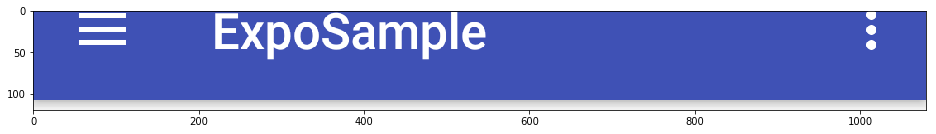

CREATE IMG


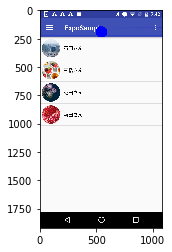

############ show rect ############
Not enough matches are found - 1/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



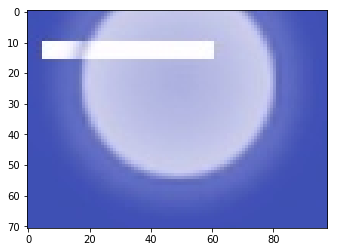

タップ:0,539,192,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


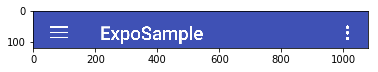

CREATE IMG


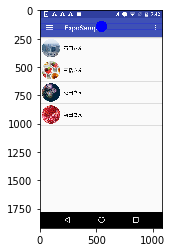

############ show rect ############
Not enough matches are found - 1/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



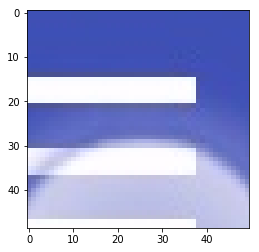

タップ:0,539,144,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y511, : x1080, y571


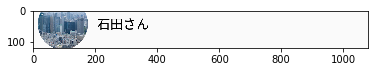

CREATE IMG


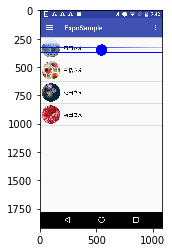

############ show rect ############
Not enough matches are found - 0/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



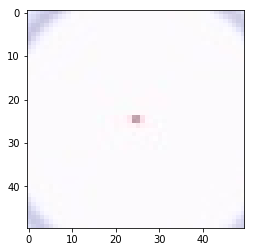

タップ:0,541,352,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y503, : x1080, y563


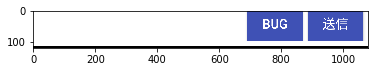

CREATE IMG


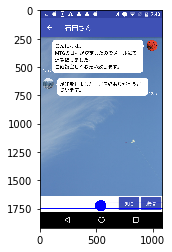

############ show rect ############
Not enough matches are found - 3/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



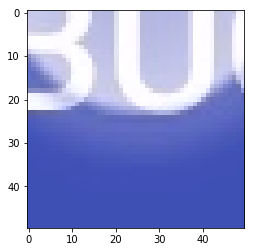

タップ:0,533,1723,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y669, : x1080, y729


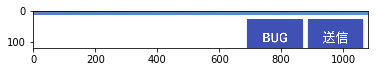

CREATE IMG


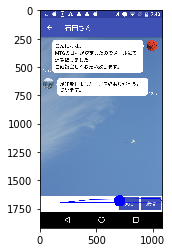

############ show rect ############
GET PARENT POS :  [0, 1620]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



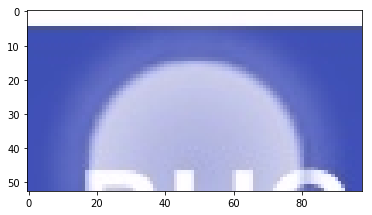

タップ:0,699,1680,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y479, : x1080, y539


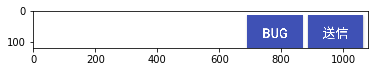

CREATE IMG


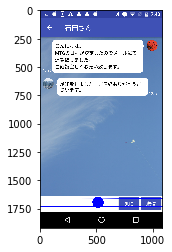

############ show rect ############
GET PARENT POS :  [0, 1634]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



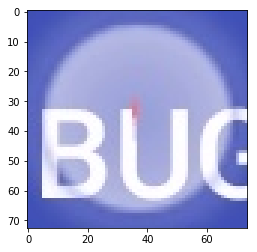

タップ:0,509,1694,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y510, : x1080, y570


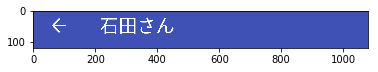

CREATE IMG


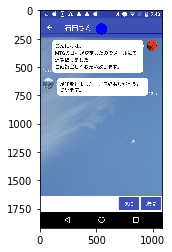

############ show rect ############
GET PARENT POS :  [0, 107]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



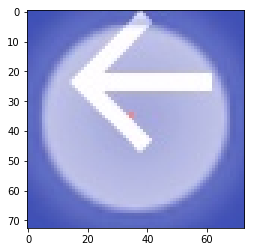

タップ:0,540,167,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y510, : x1080, y570


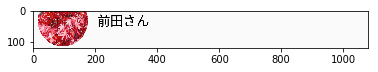

CREATE IMG


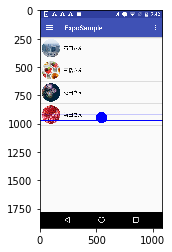

############ show rect ############
GET PARENT POS :  [0, 887]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



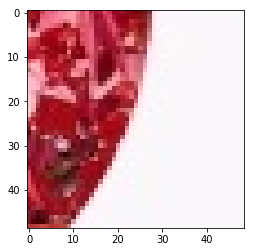

タップ:0,540,947,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y511, : x1080, y571


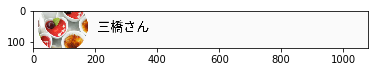

CREATE IMG


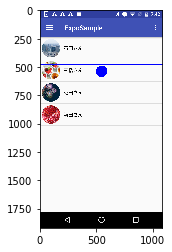

############ show rect ############
GET PARENT POS :  [0, 479]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



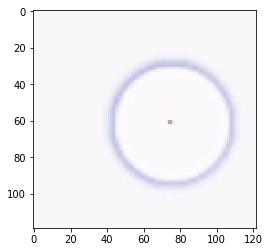

タップ:0,541,539,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


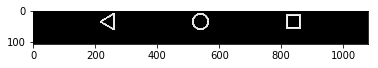

CREATE IMG


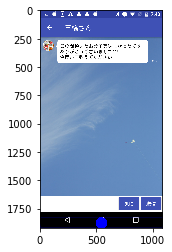

############ show rect ############
GET PARENT POS :  [0, 1814]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



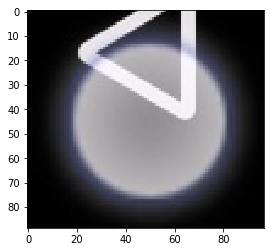

タップ:0,539,1874,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


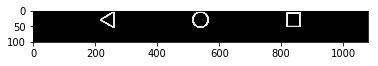

CREATE IMG


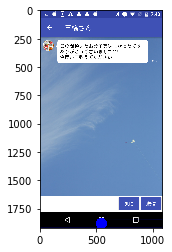

############ show rect ############
GET PARENT POS :  [0, 1820]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



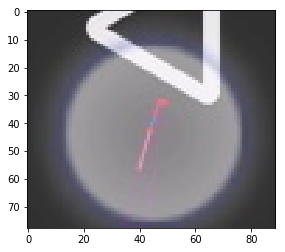

タップ:0,539,1880,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y613, : x1080, y673


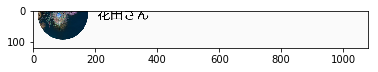

CREATE IMG


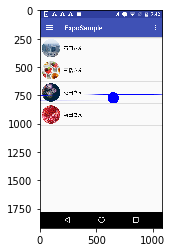

############ show rect ############
Not enough matches are found - 2/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



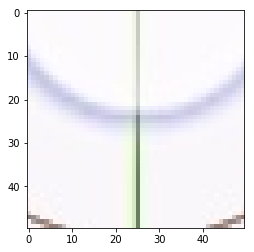

タップ:0,643,773,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y504, : x1080, y564


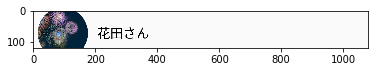

CREATE IMG


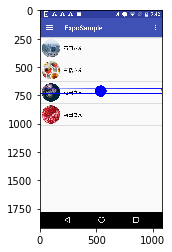

############ show rect ############
GET PARENT POS :  [0, 653]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



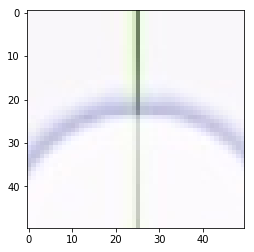

タップ:0,534,713,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y2447, : x1080, y2507
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
Image data can not convert to float



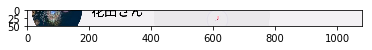

############ show rect ############
Trim IMG : x0, y-2509, : x1080, y-2449


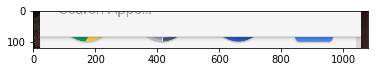

CREATE IMG


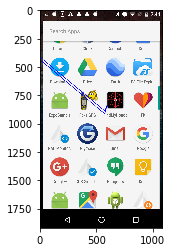

############ show rect ############
Not enough matches are found - 0/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



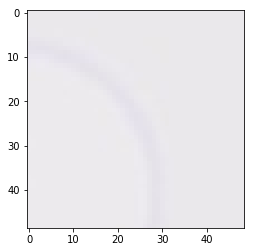

タップ:0,-2479,-1668,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


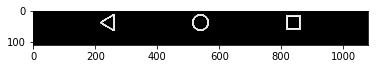

CREATE IMG


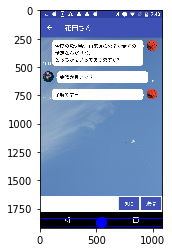

############ show rect ############
GET PARENT POS :  [0, 1811]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



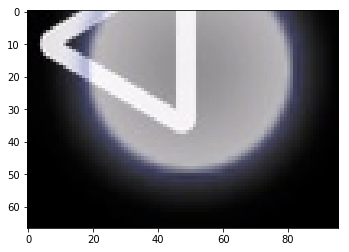

タップ:0,539,1871,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y503, : x1080, y563


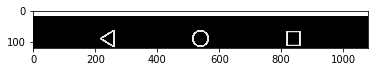

CREATE IMG


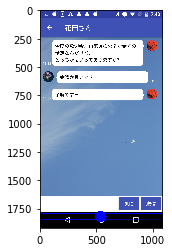

############ show rect ############
Not enough matches are found - 2/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



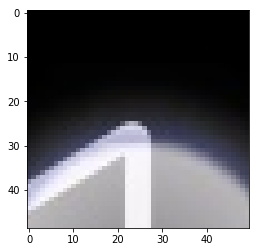

タップ:0,533,1818,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y71, : x1080, y131


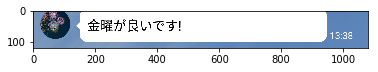

CREATE IMG


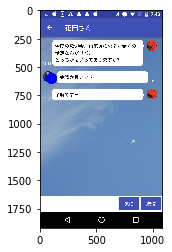

############ show rect ############
Not enough matches are found - 2/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



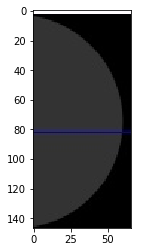

タップ:0,101,603,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y362, : x1080, y422


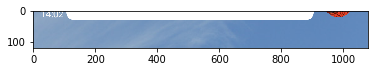

CREATE IMG


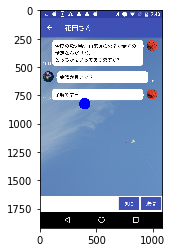

############ show rect ############
Not enough matches are found - 2/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



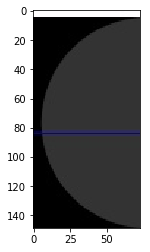

タップ:0,392,825,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


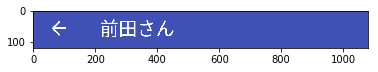

CREATE IMG


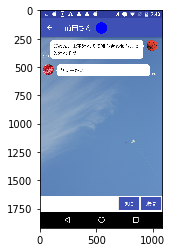

############ show rect ############
GET PARENT POS :  [0, 98]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



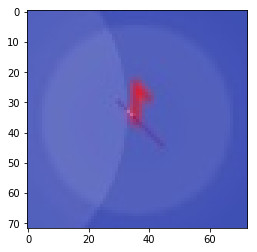

タップ:0,539,158,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


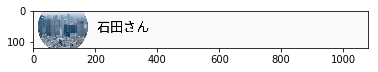

CREATE IMG


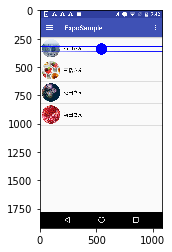

############ show rect ############
GET PARENT POS :  [0, 283]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



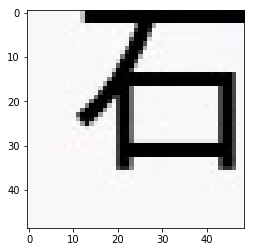

タップ:0,539,343,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


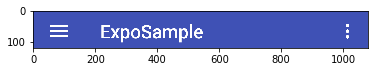

CREATE IMG


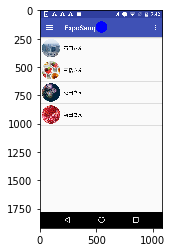

############ show rect ############
GET PARENT POS :  [0, 89]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



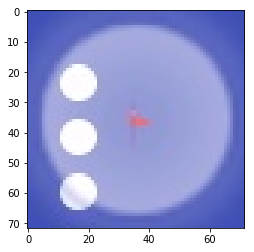

タップ:0,539,149,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


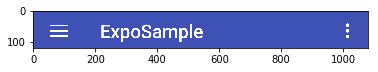

CREATE IMG


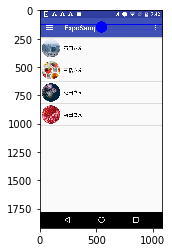

############ show rect ############
GET PARENT POS :  [0, 90]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



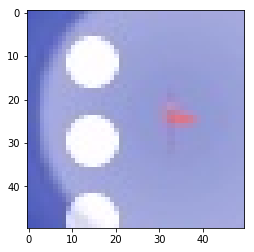

タップ:0,539,150,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y507, : x1080, y567


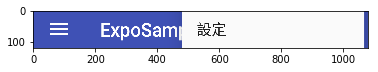

CREATE IMG


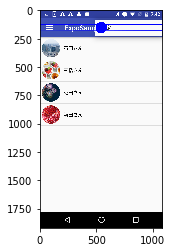

############ show rect ############
GET PARENT POS :  [0, 95]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



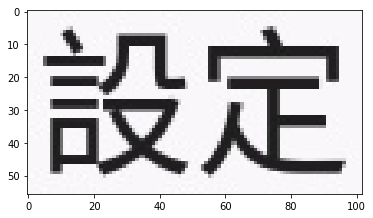

タップ:0,537,155,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


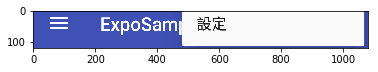

CREATE IMG


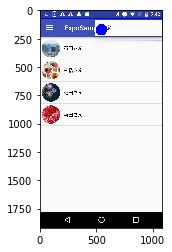

############ show rect ############
GET PARENT POS :  [0, 113]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



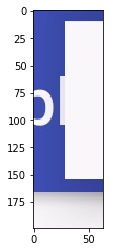

タップ:0,539,173,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
/home/monk/work/sk/build/opencv-3.2.0/modules/core/src/matmul.cpp:2271: error: (-215) scn + 1 == m.cols in function perspectiveTransform




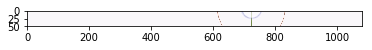

############ show rect ############
Trim IMG : x0, y37, : x1080, y97


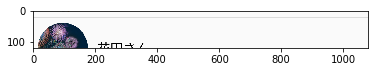

CREATE IMG


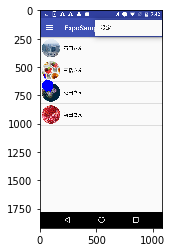

############ show rect ############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
/home/monk/work/sk/build/opencv-3.2.0/modules/core/src/matmul.cpp:2271: error: (-215) scn + 1 == m.cols in function perspectiveTransform




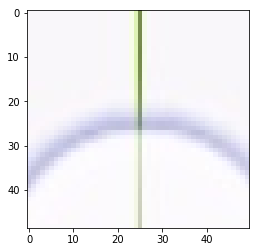

タップ:0,67,665,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y628, : x1080, y688


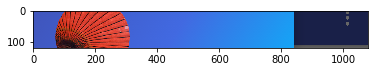

CREATE IMG


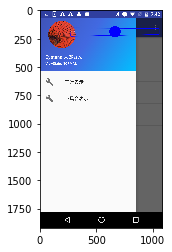

############ show rect ############
Not enough matches are found - 1/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



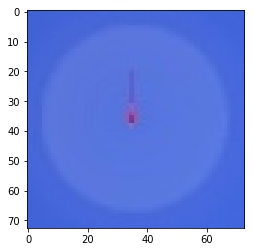

タップ:0,658,191,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y804, : x1080, y864


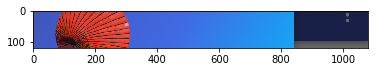

CREATE IMG


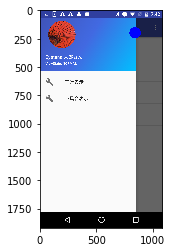

############ show rect ############
GET PARENT POS :  [0, 141]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



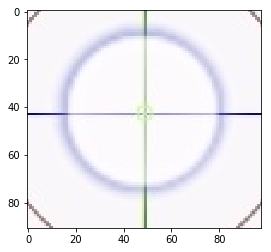

タップ:0,834,201,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y550, : x1080, y610


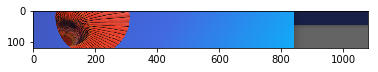

CREATE IMG


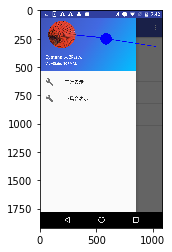

############ show rect ############
GET PARENT POS :  [0, 194]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



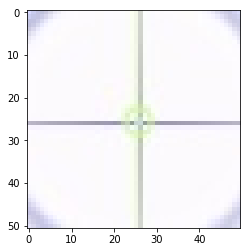

タップ:0,580,254,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


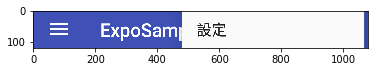

CREATE IMG


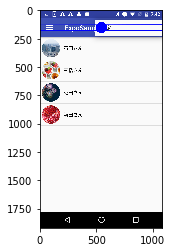

############ show rect ############
GET PARENT POS :  [0, 94]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



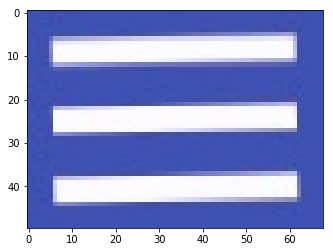

タップ:0,539,154,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y462, : x1080, y522


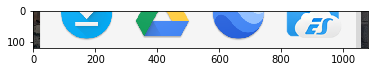

CREATE IMG


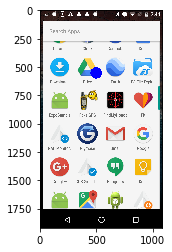

############ show rect ############
GET PARENT POS :  [0, 494]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



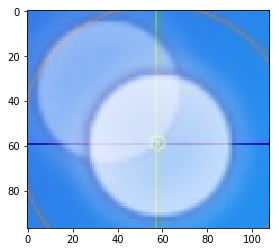

タップ:0,492,554,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


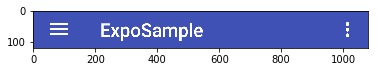

CREATE IMG


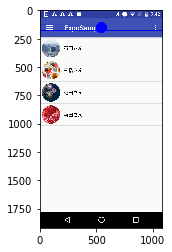

############ show rect ############
GET PARENT POS :  [0, 94]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



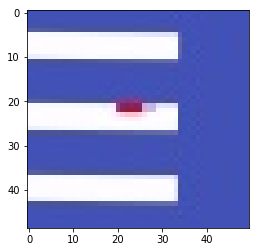

タップ:0,539,154,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


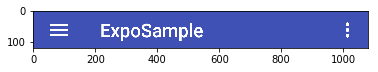

CREATE IMG


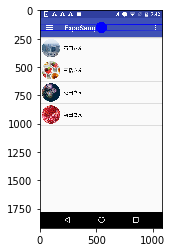

############ show rect ############
GET PARENT POS :  [0, 93]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



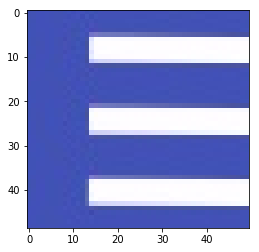

タップ:0,539,153,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


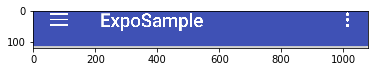

CREATE IMG


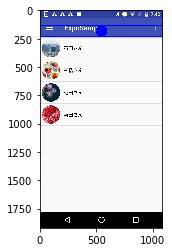

############ show rect ############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
/home/monk/work/sk/build/opencv-3.2.0/modules/core/src/matmul.cpp:2271: error: (-215) scn + 1 == m.cols in function perspectiveTransform




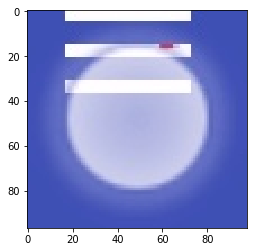

タップ:0,539,185,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Not enough matches are found - 3/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



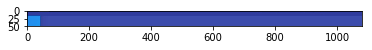

############ show rect ############
Trim IMG : x0, y350, : x1080, y410


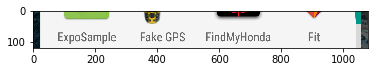

CREATE IMG


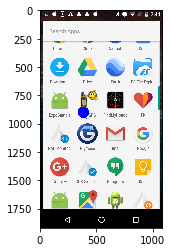

############ show rect ############
Not enough matches are found - 3/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



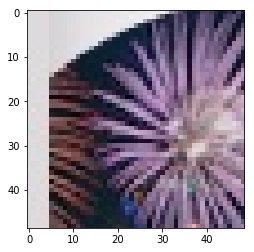

タップ:0,380,900,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


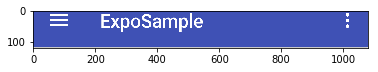

CREATE IMG


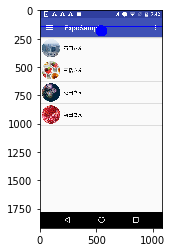

############ show rect ############
GET PARENT POS :  [0, 123]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



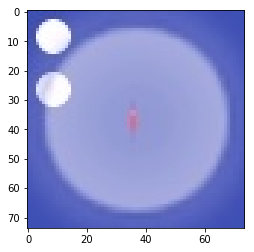

タップ:0,539,183,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


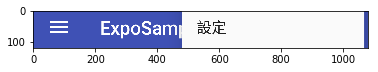

CREATE IMG


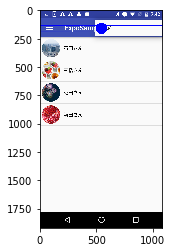

############ show rect ############
Not enough matches are found - 2/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



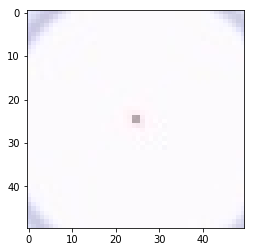

タップ:0,539,161,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y425, : x1080, y485


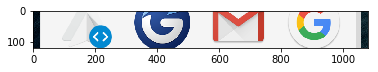

CREATE IMG


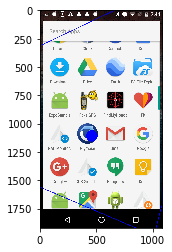

############ show rect ############
Not enough matches are found - 3/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



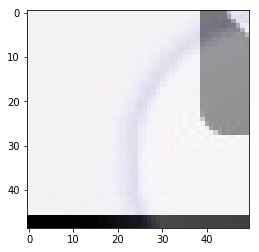

タップ:0,455,1109,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y779, : x1080, y839


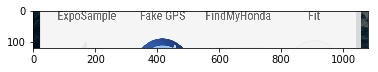

CREATE IMG


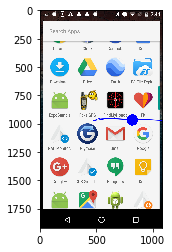

############ show rect ############
GET PARENT POS :  [0, 908]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



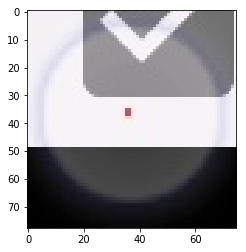

タップ:0,809,968,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y507, : x1080, y567


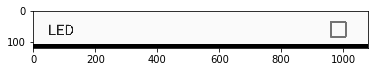

CREATE IMG


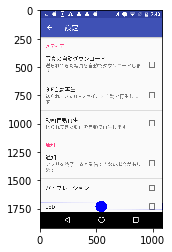

############ show rect ############
GET PARENT POS :  [0, 1670]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



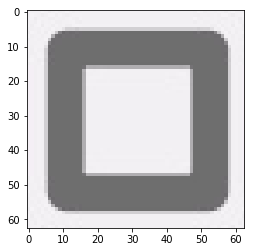

タップ:0,537,1730,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y489, : x1080, y549


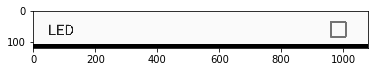

CREATE IMG


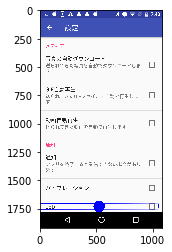

############ show rect ############
Not enough matches are found - 3/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



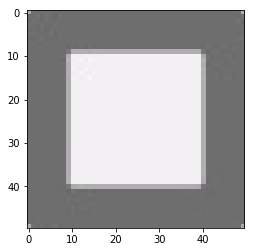

タップ:0,519,1730,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


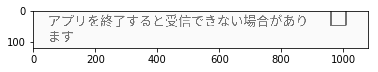

CREATE IMG


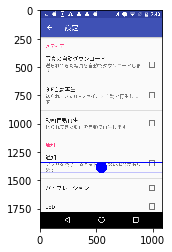

############ show rect ############
GET PARENT POS :  [0, 1325]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



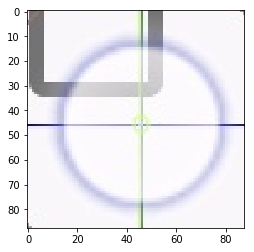

タップ:0,539,1385,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y434, : x1080, y494


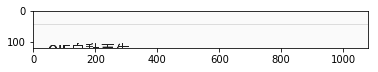

CREATE IMG


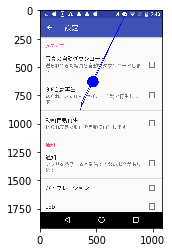

############ show rect ############
Not enough matches are found - 3/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



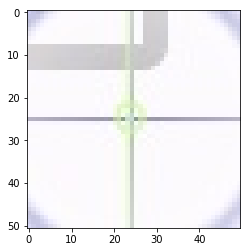

タップ:0,464,632,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


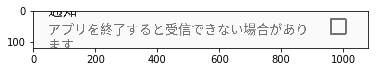

CREATE IMG


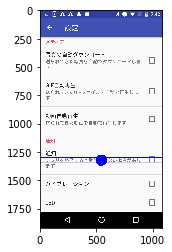

############ show rect ############
Not enough matches are found - 1/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



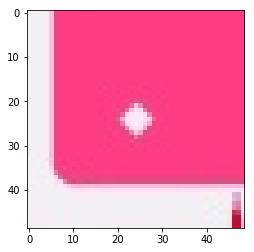

タップ:0,539,1322,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


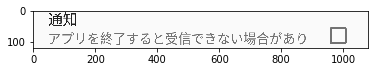

CREATE IMG


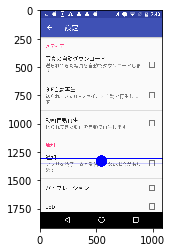

############ show rect ############
Not enough matches are found - 2/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



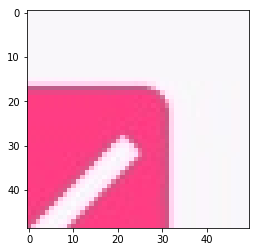

タップ:0,539,1329,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


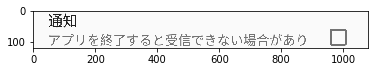

CREATE IMG


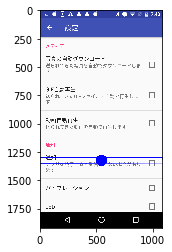

############ show rect ############
Not enough matches are found - 1/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



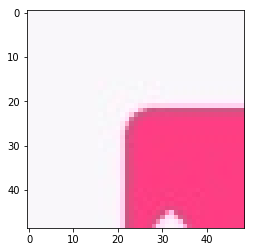

タップ:0,539,1324,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


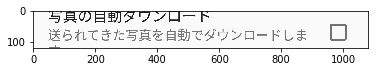

CREATE IMG


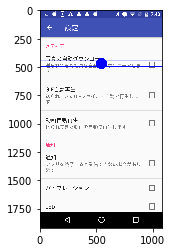

############ show rect ############
Not enough matches are found - 2/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



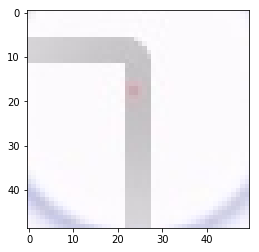

タップ:0,539,471,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


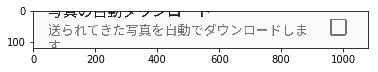

CREATE IMG


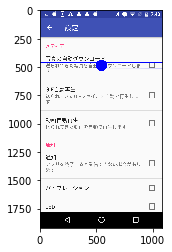

############ show rect ############
Not enough matches are found - 2/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



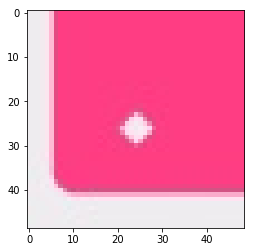

タップ:0,539,487,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


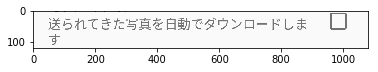

CREATE IMG


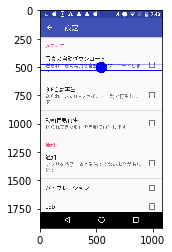

############ show rect ############
Not enough matches are found - 0/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



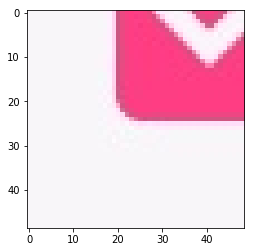

タップ:0,539,506,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


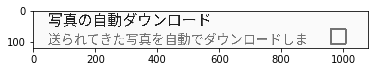

CREATE IMG


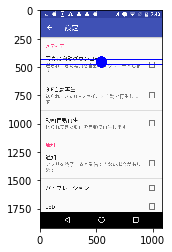

############ show rect ############
Not enough matches are found - 1/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



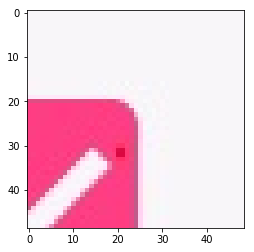

タップ:0,539,458,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y510, : x1080, y570


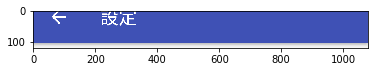

CREATE IMG


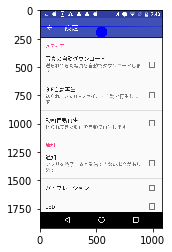

############ show rect ############
GET PARENT POS :  [0, 135]
############### TAP IMAGE!!!!!!!! ###############
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
integer argument expected, got float



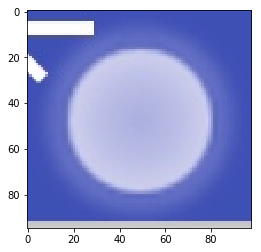

タップ:0,540,195,0,0,0
待機:10,10,0,0,0,0
############ show rect ############
Trim IMG : x0, y508, : x1080, y568


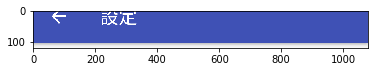

CREATE IMG


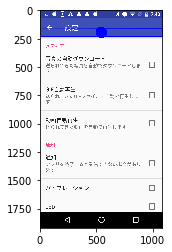

############ show rect ############
Not enough matches are found - 0/4
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
No active exception to reraise



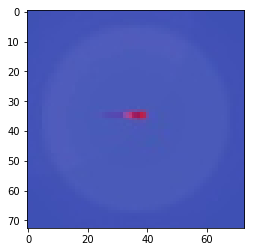

タップ:0,538,196,0,0,0
待機:10,10,0,0,0,0


In [8]:
if __name__ == '__main__':
    f = open('base_senario.json', 'r')
    data = json.load(f)
    # print(data)
    # 解像度
    scale='#540*888#'
    print(scale)
    cf = CompareFeatures()
    for key in data:
        bs=data[key]
        try:
            pos = ()
    #         print(bs['line']['base'], " : ", bs['line']['match'])
            cf.load_imgs(bs['line']['base'],bs['line']['match'],scale=(1,bs['line']['scale']))
    #         print(type(cf.base), type(cf.match))
    #         cf.get_postion(IS_PARENT=True)
            pos = cf.show_rect(IS_PARENT=True)
    #         print("################### PARENT Finish ###################")
    #         print(bs['tap']['base'], " : ", bs['tap']['match'])
            cf.load_imgs(bs['tap']['base'],bs['tap']['match'],scale=(1,bs['tap']['scale']))
    #         print(type(cf.base), type(cf.match))

#             pos = cf.get_postion()
            pos = cf.show_rect()
        except Exception as e:
            print("############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############\n{0}\n".format(e))
            cf.view_matplot(cf.match)
            pass
        if pos:
            print("タップ:0,{0},{1},0,0,0".format(int(pos[0]),int(pos[1])))
            print("待機:10,10,0,0,0,0")